<a href="https://colab.research.google.com/github/cerysojj/micaflow/blob/main/toybox_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and define MLP class

In [3]:
#Pytorch Implementation of a 2 Layer MLP
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import time

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix

In [4]:
class MLP(nn.Module):
  def __init__(self, input_size=784, num_classes=10, layers=[128, 64]):
    super(MLP, self).__init__()
    #Define the layers in your MLP
    self.d1 = nn.Linear(input_size, layers[0])  # input layer
    self.d2 = nn.Linear(layers[0], layers[1])   # hidden layer
    self.d3 = nn.Linear(layers[1], num_classes) # output layer

  def forward(self, x):
    #Define operations on input x using the layers that were defined
    x = F.relu(self.d1(x))
    x = F.relu(self.d2(x))
    x = F.log_softmax(self.d3(x), dim=1)
    return x

# Training model on MNIST

In [ ]:
#Initalize your MLP
model = MLP()

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#define hyperparameters
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

Transform = transforms.ToTensor()
train = MNIST(root='data/', train=True, download=True, transform=Transform)
test = MNIST(root='data/', train=False, download=True, transform=Transform)

--2024-10-02 17:13:30--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-10-02 17:13:30--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [          <=>       ]  33.20M  8.27MB/s    in 4.8s    

2024-10-02 17:13:35 (6.85 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

100%|██████████| 9912422/9912422 [00:00<00:00, 15867635.17it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 497036.28it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4395110.77it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2364175.82it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
image, label = train[0]
print('Shape:', image.shape, '\nlabel:', label)

Shape: torch.Size([1, 28, 28]) 
label: 5


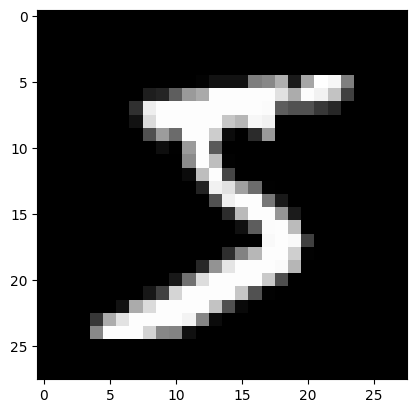

In [ ]:
plt.imshow(image[0], cmap='gray')

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=500, shuffle=False)

In [ ]:
for image, label in train_loader:
  print('Image:', image.shape, '\nLabel:', label.shape)
  break
print('Batch shape after flattening:', image.view(100, -1).size())

Image: torch.Size([100, 1, 28, 28]) 
Label: torch.Size([100])
Batch shape after flattening: torch.Size([100, 784])


In [ ]:
#Training loop
epochs = 10
train_losses = []
train_correct = []
test_losses = []
test_correct = []
start_time = time.time()

for t in range(epochs):
    train_corr = 0
    test_corr = 0
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(x_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        optimizer.zero_grad() #reset the gradients from previous batch
        loss.backward() #backpropagation
        optimizer.step() #update the model's parameters based on the gradients

        if b%200 == 0:
            print(f'Epoch {t} Loss: {loss.item()} Accuracy: {train_corr.item()*100/(100*b)}%')

    train_losses.append(loss)
    train_correct.append(train_corr)

    with torch.no_grad(): # forward pass without computing gradients
        for b, (x_test, y_test) in enumerate(test_loader):
            y_val = model(x_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch 0 Loss: 2.222351312637329 Accuracy: 21.595%
Epoch 0 Loss: 2.034365653991699 Accuracy: 36.1425%
Epoch 0 Loss: 1.502158761024475 Accuracy: 44.653333333333336%
Epoch 1 Loss: 0.8779550194740295 Accuracy: 72.59%
Epoch 1 Loss: 0.8179147839546204 Accuracy: 75.4975%
Epoch 1 Loss: 0.6974050998687744 Accuracy: 77.58166666666666%
Epoch 2 Loss: 0.6142518520355225 Accuracy: 83.91%
Epoch 2 Loss: 0.5294088125228882 Accuracy: 84.82%
Epoch 2 Loss: 0.45477789640426636 Accuracy: 85.44166666666666%
Epoch 3 Loss: 0.40274661779403687 Accuracy: 87.58%
Epoch 3 Loss: 0.4266878068447113 Accuracy: 87.805%
Epoch 3 Loss: 0.34935474395751953 Accuracy: 88.085%
Epoch 4 Loss: 0.3200691342353821 Accuracy: 89.345%
Epoch 4 Loss: 0.3625234365463257 Accuracy: 89.345%
Epoch 4 Loss: 0.3990757465362549 Accuracy: 89.22166666666666%
Epoch 5 Loss: 0.30073556303977966 Accuracy: 89.755%
Epoch 5 Loss: 0.4766848683357239 Accuracy: 89.8325%
Epoch 5 Loss: 0.3985399901866913 Accuracy: 89.85166666666667%
Epoch 6 Loss: 0.2353107035

In [ ]:
# Test accuracy for last epoch
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 91.920%


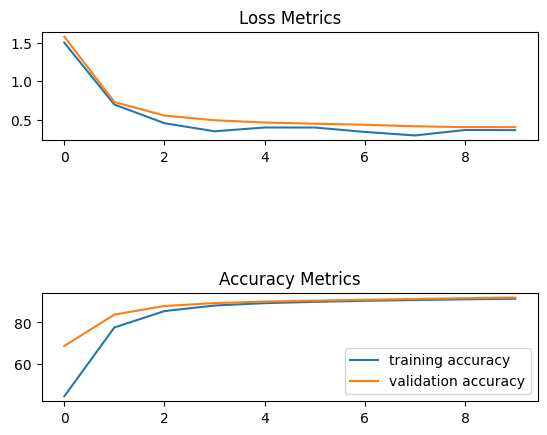

In [ ]:
plt.subplot(3, 1, 1)
plt.plot([loss.detach().numpy() for loss in train_losses], label='training loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='validation loss')
plt.title('Loss Metrics')

plt.subplot(3, 1, 3)
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy Metrics')

plt.legend()

# Training model on Toybox

## Load the data onto Google Drive

In [6]:
import requests
import os
from google.colab import drive

drive.mount('/content/drive')

# Save animals data to google drive
save_path = '/content/drive/My Drive/animals.tar.gz'

if not os.path.exists(save_path):
    animals = "https://zenodo.org/records/1289936/files/animals.tar.gz?download=1"
    response = requests.get(animals, stream=True)

    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("File downloaded and saved to Google Drive")
else:
    print("File already exists in Google Drive")

Mounted at /content/drive
File already exists in Google Drive


In [7]:
# Save households data to google drive
save_path = '/content/drive/MyDrive/households.tar.gz'

if not os.path.exists(save_path):
    households = "https://zenodo.org/records/1290019/files/households.tar.gz?download=1"
    response = requests.get(households, stream=True)

    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("File downloaded and saved to Google Drive")
else:
    print("File already exists in Google Drive")

File already exists in Google Drive


In [8]:
# Save vehicles data to google drive
save_path = '/content/drive/MyDrive/vehicles.tar.gz'

if not os.path.exists(save_path):
  vehicles = "https://zenodo.org/records/1290757/files/vehicles.tar.gz?download=1"
  response = requests.get(vehicles, stream=True)

  with open(save_path, "wb") as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
  print("File downloaded and saved to Google Drive")
else:
    print("File already exists in Google Drive")

File downloaded and saved to Google Drive


## Extract the files from Google Drive

In [10]:
households = '/content/drive/MyDrive/households.tar.gz'
animals = '/content/drive/MyDrive/animals.tar.gz'
vehicles = '/content/drive/MyDrive/vehicles.tar.gz'

In [ ]:
import tarfile

for file in [households, animals, vehicles]:
  if tarfile.is_tarfile(file):
      with tarfile.open(file, 'r:gz') as tar:
          tar.extractall(path='/content/toybox_data')  # Extract to a folder in Colab workspace
      print("File extracted successfully")
  else:
      print("Not a valid tar.gz file")

In [11]:
if tarfile.is_tarfile(vehicles):
    with tarfile.open(vehicles, 'r:gz') as tar:
        tar.extractall(path='/content/toybox_data')  # Extract to a folder in Colab workspace
    print("File extracted successfully")
else:
    print("Not a valid tar.gz file")

File extracted successfully


## Explore the files

In [23]:
import os
import random

# Set the path to your directory
toybox_path = '/content/toybox_data'

# Collect all file paths
file_paths = []
for root, dirs, files in os.walk(toybox_path):
    for name in files:
        file_paths.append(os.path.join(root, name))

# Ensure we have enough files
if len(file_paths) < 100:
    raise ValueError("Not enough files in the directory. Please ensure there are at least 100 files.")

# Randomly shuffle the file paths
random.shuffle(file_paths)

# Select the first 85 for training and the next 15 for testing
train_paths = file_paths[:85]
test_paths = file_paths[85:100]

In [26]:
labels = {}

for path in file_paths:
    # Split the path and extract the desired label (the second part)
    label = path.split('/')[4].split('_')[0]  # This gets 'horse', 'dog', 'car'
    labels[path] = label

# Output the results
for filepath, label in labels.items():
    print(f"Filepath: {filepath}, Label: {label}")

Filepath: /content/toybox_data/animals/horse_18_pivothead/horse_18_pivothead_rzplus.mp4, Label: horse
Filepath: /content/toybox_data/animals/duck_11_pivothead/duck_11_pivothead_rxminus.mp4, Label: duck
Filepath: /content/toybox_data/animals/giraffe_11_pivothead/giraffe_11_pivothead_ryminus.mp4, Label: giraffe
Filepath: /content/toybox_data/animals/horse_30_pivothead/horse_30_pivothead_tx.mp4, Label: horse
Filepath: /content/toybox_data/animals/duck_26_pivothead/duck_26_pivothead_rxminus.mp4, Label: duck
Filepath: /content/toybox_data/animals/duck_25_pivothead/duck_25_pivothead_ryplus.mp4, Label: duck
Filepath: /content/toybox_data/animals/cat_06_pivothead/cat_06_pivothead_rzplus.mp4, Label: cat
Filepath: /content/toybox_data/animals/duck_27_pivothead/duck_27_pivothead_rzminus.mp4, Label: duck
Filepath: /content/toybox_data/animals/giraffe_21_pivothead/giraffe_21_pivothead_rzplus.mp4, Label: giraffe
Filepath: /content/toybox_data/vehicles/airplane_11_pivothead/airplane_11_pivothead_rymi

In [28]:
file_paths = list(labels.keys())

# Randomly shuffle the file paths
random.shuffle(file_paths)

# Select 85 for training and 15 for testing
train_set = file_paths[:85]
test_set = file_paths[85:100]

# Prepare the corresponding labels for each set
train_labels = [labels[path] for path in train_set]
test_labels = [labels[path] for path in test_set]

### Counting number of frames in each mp4 video

In [29]:
import cv2

def get_frame_count(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Get the total number of frames
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    cap.release()

    return frame_count

vid = '/content/toybox_data/animals/giraffe_17_pivothead/giraffe_17_pivothead_rxplus.mp4'
frames = get_frame_count(vid)
print(f"Number of frames: {frames}")

Number of frames: 639


### Extract frames from each mp4 video

In [30]:
def extract_frames(video_path, output_folder):
    """Extract frames from a video and save them as images."""
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit if there are no more frames

        # Save the current frame as an image file
        frame_filename = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        frame_count += 1

    # Release the video capture object
    cap.release()
    print(f"Extracted {frame_count} frames from {video_path}.")

# Extract frames from training set
for video in train_set:
    output_folder = os.path.join('/content/toybox_data/extracted_frames/train', os.path.basename(video).split('.')[0])
    extract_frames(video, output_folder)

# Extract frames from testing set
for video in test_set:
    output_folder = os.path.join('/content/toybox_data/extracted_frames/test', os.path.basename(video).split('.')[0])
    extract_frames(video, output_folder)

Extracted 652 frames from /content/toybox_data/households/mug_28_pivothead/mug_28_pivothead_rzplus.mp4.
Extracted 664 frames from /content/toybox_data/vehicles/truck_22_pivothead/truck_22_pivothead_ty.mp4.
Extracted 673 frames from /content/toybox_data/vehicles/airplane_18_pivothead/airplane_18_pivothead_rxminus.mp4.
Extracted 637 frames from /content/toybox_data/households/spoon_25_pivothead/spoon_25_pivothead_tx.mp4.
Extracted 106 frames from /content/toybox_data/vehicles/truck_30_pivothead/truck_30_pivothead_absent.mp4.
Extracted 661 frames from /content/toybox_data/animals/giraffe_23_pivothead/giraffe_23_pivothead_ryminus.mp4.
Extracted 628 frames from /content/toybox_data/households/ball_04_pivothead/ball_04_pivothead_ryplus.mp4.
Extracted 562 frames from /content/toybox_data/animals/horse_09_pivothead/horse_09_pivothead_tx.mp4.
Extracted 652 frames from /content/toybox_data/households/mug_19_pivothead/mug_19_pivothead_rxminus.mp4.
Extracted 637 frames from /content/toybox_data/ho

In [33]:
import os
from PIL import Image  # Make sure you have Pillow installed

# Base path where the frames are stored
base_frame_path = '/content/toybox_data/extracted_frames'

# Initialize empty dictionaries to hold the images and labels for train and test
train_data = {}
test_data = {}

# Define directories to process
directories = ['train', 'test']
data_dicts = [train_data, test_data]  # List to hold the corresponding dictionaries

# Loop through train and test directories
for dataset, data_dict in zip(directories, data_dicts):
    frames_folder = os.path.join(base_frame_path, dataset)  # Get the path for train or test
    for class_folder in os.listdir(frames_folder):
        class_path = os.path.join(frames_folder, class_folder)

        if os.path.isdir(class_path):  # Ensure it's a directory
            for frame_file in os.listdir(class_path):
                if frame_file.endswith('.jpg'):
                    # Create the full path to the frame
                    frame_path = os.path.join(class_path, frame_file)
                    # Extract label from the frame filename
                    label = frame_file.split('_')[0]  # Gets the label (e.g., 'dog', 'car')

                    # Open the image and save it to the respective dictionary
                    image = Image.open(frame_path)  # Read the image
                    data_dict[frame_file] = (image, label)  # Save the image and label

# Output the results
print("Training Data:")
for frame_file, (image, label) in train_data.items():
    print(f"File: {frame_file}, Label: {label}")

print("\nTesting Data:")
for frame_file, (image, label) in test_data.items():
    print(f"File: {frame_file}, Label: {label}")


Streaming output truncated to the last 5000 lines.
File: mug_13_pivothead_hodgepodge.mp4_frame_0604.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0247.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0149.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0099.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0191.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0094.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0177.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0317.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0058.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0613.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0616.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0595.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0554.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_frame_0229.jpg, Label: mug
File: mug_13_pivothead_hodgepodge.mp4_f

In [34]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/toybox_data/extracted_frames /content/drive/MyDrive/toybox_sample
!ls /content/extracted_frames /content/drive/MyDrive/toybox_sample

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C
ls: cannot access '/content/extracted_frames': No such file or directory
/content/drive/MyDrive/toybox_sample:
train


In [ ]:
import pickle

# Define paths to save the dictionaries
train_data_path = '/content/drive/My Drive/toybox_train.pkl'
test_data_path = '/content/drive/My Drive/toybox_test.pkl'

# Save the dictionaries to pickle files
with open(train_data_path, 'wb') as f:
    pickle.dump(train_data, f)

with open(test_data_path, 'wb') as f:
    pickle.dump(test_data, f)

print("Train and test data saved successfully.")

## Load the data

In [ ]:
csv_file_path = '/content/vehicles_data/your_data_file.csv'  # Adjust this path
df = pd.read_csv(csv_file_path)

print(df.head())

## Train the model

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=500, shuffle=False)

In [ ]:
# Check shapes
for image, label in train_loader:
  print('Image:', image.shape, '\nLabel:', label.shape)
  break
print('Batch shape after flattening:', image.view(100, -1).size())

In [ ]:
#Initalize your MLP
toybox_mdl = MLP(input_size=784, num_classes=10, layers=[128, 64])

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
#Training loop
epochs = 10
train_losses = []
train_correct = []
test_losses = []
test_correct = []
start_time = time.time()

for t in range(epochs):
    train_corr = 0
    test_corr = 0
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(x_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        optimizer.zero_grad() #reset the gradients from previous batch
        loss.backward() #backpropagation
        optimizer.step() #update the model's parameters based on the gradients

        if b%200 == 0:
            print(f'Epoch {t} Loss: {loss.item()} Accuracy: {train_corr.item()*100/(100*b)}%')

    train_losses.append(loss)
    train_correct.append(train_corr)

    with torch.no_grad(): # forward pass without computing gradients
        for b, (x_test, y_test) in enumerate(test_loader):
            y_val = model(x_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

In [ ]:
# Test accuracy for last epoch
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

In [ ]:
plt.subplot(3, 1, 1)
plt.plot([loss.detach().numpy() for loss in train_losses], label='training loss')
plt.plot([loss.detach().numpy() for loss in test_losses], label='validation loss')
plt.title('Loss Metrics')

plt.subplot(3, 1, 3)
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy Metrics')

plt.legend()